# 「ベイズ推論による機械学習入門」
#   P.145 ガウス混合モデルに対するギブスサンプリング

In [1]:
using Distributions
using LinearAlgebra
using PDMats
using Plots
using StatsFuns

## 真のモデル

In [2]:
𝐷 = 2
𝐾 = 3

μ₁_true = [0.0; 5.0]
μ₂_true = [-5.0; 2.0]
μ₃_true = [5.0; -2.0]

Σ₁_true = [
    1.0 0.0
    0.0 2.0
]

Σ₂_true = [
    0.5 0.75
    0.75 2.0
]

Σ₃_true = [
    0.5 0.1
    0.1 0.5
]

π_true = [0.4, 0.35, 0.25]

mult_gauss_true = MvNormal[
    MvNormal(μ₁_true, Σ₁_true), 
    MvNormal(μ₂_true, Σ₂_true), 
    MvNormal(μ₃_true, Σ₃_true)
]

true_model = MixtureModel(mult_gauss_true, π_true);

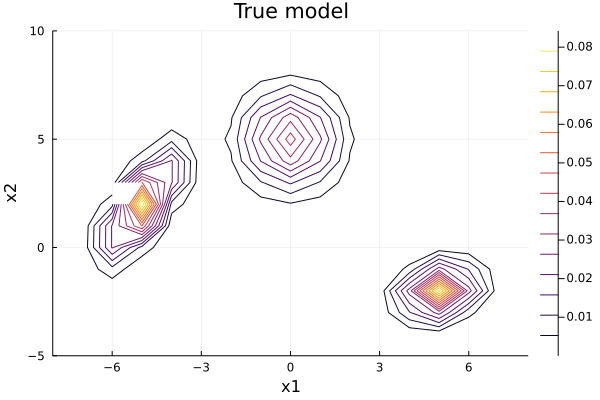

In [3]:
contour(-8:8, -5:10, (x, y) -> pdf(true_model, [x, y]), title="True model", xlabel="x1", ylabel="x2")

## 観測データの生成

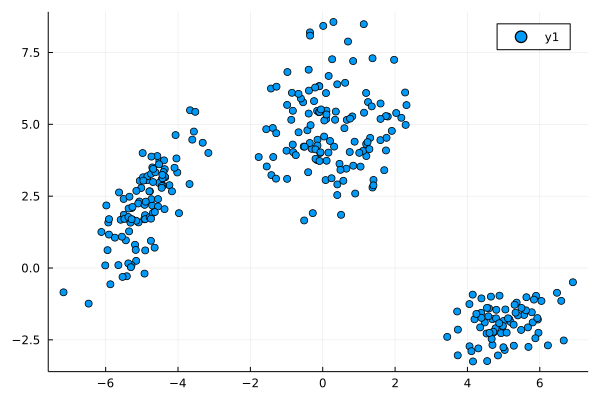

In [4]:
𝑁 = 300

μ_obs = [
    [μ₁_true]
    [μ₂_true]
    [μ₃_true]
]

Σ_obs = [
    [Σ₁_true]
    [Σ₂_true]
    [Σ₃_true]
]

mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, 𝑁)
cluster_num = mapslices(argmax, S_obs, dims=1)

𝐗 = zeros(𝑁, 𝐷)
for n in 1:𝑁
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    𝐗[n, :] = rand(mult_gauss_obs)
end

𝐗[1:10, :]
scatter(𝐗[:, 1], 𝐗[:, 2])

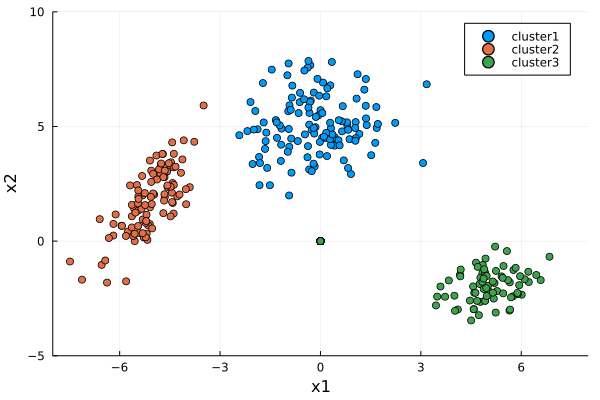

In [5]:
each_cluster = [zeros(𝐷, 𝑁), zeros(𝐷, 𝑁), zeros(𝐷, 𝑁)]
for n in 1:𝑁
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    each_cluster[k][:, n] = rand(mult_gauss_obs) 
end

p = plot(xlabel="x1", ylabel="x2", xlim=(-8,8), ylim=(-5,10))
for k in 1:𝐾
    scatter!(p, each_cluster[k][1, :], each_cluster[k][2, :], label="cluster$k")
end
p

## ギブスサンプリング

### パラメータの初期化

In [6]:
# 超パラメータを設定（クラスタ間をまたがって共通と仮定）
𝐦 = rand(𝐷)
β = 1.0
𝐖 = Matrix(1.0I, 𝐷, 𝐷)
ν = 𝐷

# パラメータのサンプル μ,Λ,π に初期値を設定
𝚲 = zeros(𝐷, 𝐷, 𝐾)
𝛍 = zeros(𝐾, 𝐷)
for k in 1:𝐾
    𝚲[:, :, k] = rand(Wishart(ν, 𝐖))
    𝛍[k, :] =　rand(MvNormal(𝐦, PDMat(Symmetric(inv(β * 𝚲[:, :, k])))))
end

α = ones(𝐾)
𝛑 = rand(Dirichlet(α))

3-element Vector{Float64}:
 0.034827247102873875
 0.24469223690119105
 0.7204805159959351

### パラメータの更新即

maxiter=1の場合で各計算を確認する。

In [7]:
# 潜在変数Sをサンプル
ηₙₖ = zeros(𝑁, 𝐾)
for k in 1:𝐾
    for n in 1:𝑁
        𝐱ₙ = 𝐗[n, :]
        𝛍ₖ = 𝛍[k, :]
        𝚲ₖ = 𝚲[:, :, k]
        tmp = -0.5 * (𝐱ₙ - 𝛍ₖ)' * 𝚲ₖ * (𝐱ₙ - 𝛍ₖ)
        lnηₙₖ = tmp + 0.5 * logdet(𝚲ₖ) + log(𝛑[k])
        ηₙₖ[n, k] = exp(lnηₙₖ - logsumexp(lnηₙₖ))
    end
end
ηₙₖ = ηₙₖ ./ sum(ηₙₖ, dims=2)

𝑆 = zeros(𝑁, 𝐾)
for n in 1:𝑁
    𝑆[n, :] = rand(Multinomial(1, ηₙₖ[n, :]))
end

# パラメータμ, Λをサンプル
β̂ = vec(sum(𝑆, dims=1)) .+ β
ν̂ = vec(sum(𝑆, dims=1)) .+ ν
𝐦̂ = zeros(𝐾, 𝐷)
𝐖̂ = zeros(𝐷, 𝐷, 𝐾)
𝚲̂ = zeros(𝐷, 𝐷, 𝐾)
𝛍̂ = zeros(𝐾, 𝐷)
for k in 1:𝐾
    𝐦̂[k, :] = (sum(𝑆[n, k] * 𝐗[n, :] for n in 1:𝑁) + β * 𝐦) ./ β̂[k]
    𝐦̂ₖ = 𝐦̂[k, :]
    β̂ₖ = β̂[k]
    𝐖⁻¹ = inv(𝐖)
    𝐖̂[:, :, k] = inv(sum(𝑆[n, k] * 𝐗[n, :] * 𝐗[n, :]' for n in 1:𝑁) + β * 𝐦 * 𝐦' - β̂ₖ * 𝐦̂ₖ * 𝐦̂ₖ' + 𝐖⁻¹)
    
    𝚲̂[:, :, k] = rand(Wishart(ν̂[1], PDMat(Symmetric(𝐖̂[:, :, 1]))))
    
    invβ̂ₖ𝚲̂ₖ = inv(β̂[k] * 𝚲̂[:, :, k])
    𝛍̂[k, :] = rand(MvNormal(𝐦̂[1, :], invβ̂ₖ𝚲̂ₖ))
end

# 混合比率πをサンプル
α̂ = vec(sum(𝑆, dims=1)) .+ α
𝛑̂ = rand(Dirichlet(α̂));

In [8]:
𝚲̂

2×2×3 Array{Float64, 3}:
[:, :, 1] =
 0.0888227  0.035016
 0.035016   0.195225

[:, :, 2] =
 0.0873243  0.0216538
 0.0216538  0.116853

[:, :, 3] =
 0.0804515  0.0320339
 0.0320339  0.144985

In [9]:
𝛍̂

3×2 Matrix{Float64}:
 -0.393446  2.41198
 -0.726377  2.50434
 -1.21789   2.88225

In [10]:
𝛑̂

3-element Vector{Float64}:
 0.3628129501136623
 0.291017378759903
 0.34616967112643465

maxiter=100にして繰り返す。